                       1. open    2. high  5. volume   4. close     3. low
date                                                                      
2018-04-09 09:30:00  1425.0300  1426.0000    40029.0  1424.9900  1424.9900
2018-04-09 09:31:00  1425.9500  1426.0000    27094.0  1423.6000  1422.2300
2018-04-09 09:32:00  1423.6600  1424.6600    30505.0  1420.9947  1417.8500
2018-04-09 09:33:00  1422.5699  1422.5700    16320.0  1418.4400  1418.4400
2018-04-09 09:34:00  1419.4800  1421.8069    24499.0  1421.8069  1416.0700
2018-04-09 09:35:00  1420.5000  1423.4800    16098.0  1422.9995  1418.0000
2018-04-09 09:36:00  1422.2000  1423.6868    19341.0  1423.2500  1420.0000
2018-04-09 09:37:00  1423.0700  1424.8000    17138.0  1423.0000  1422.0000
2018-04-09 09:38:00  1423.0000  1423.0588    12292.0  1421.5644  1420.5050
2018-04-09 09:39:00  1421.6992  1422.3588    11872.0  1417.0800  1417.0800
2018-04-09 09:40:00  1418.3400  1419.3100    12219.0  1418.1700  1417.6800
2018-04-09 09:41:00  1419

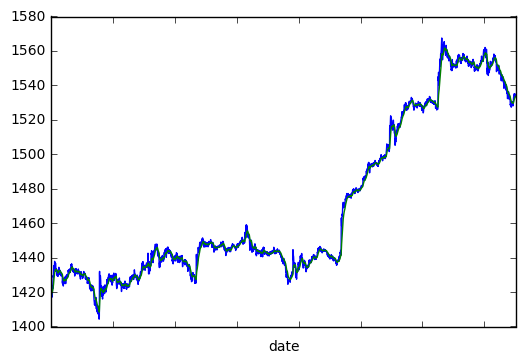

2018-04-13 14:48:00 2018-04-20 13:29:00 1876


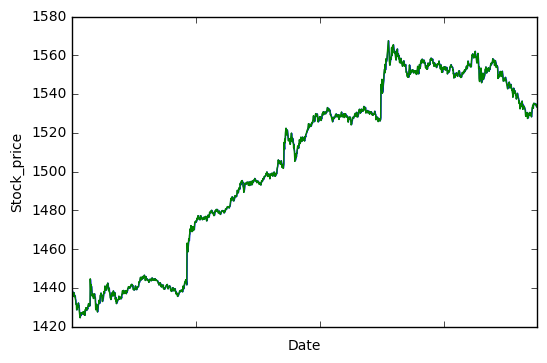

[[ 0.04443685]
 [-0.0247779 ]
 [ 0.9803763 ]]
-0.014586999837338646 1.2512698226589565 -0.011809466412843639 1.2529858060427483


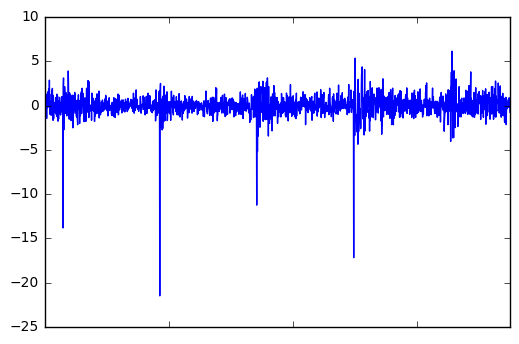

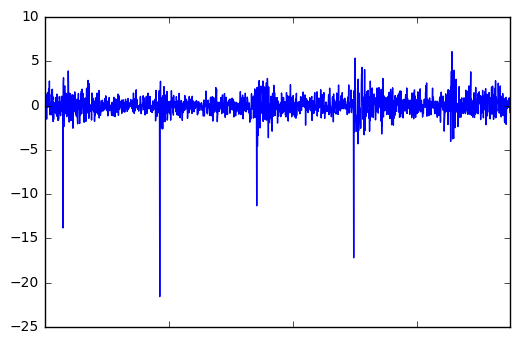

[[1.         0.99961362]
 [0.99961362 1.        ]]
[[1.         0.99961259]
 [0.99961259 1.        ]]


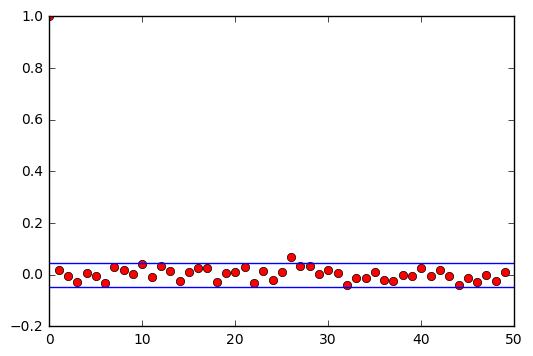

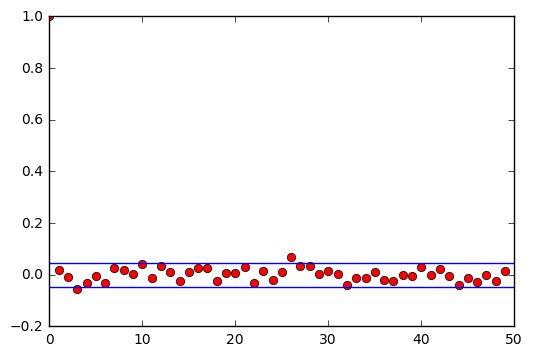

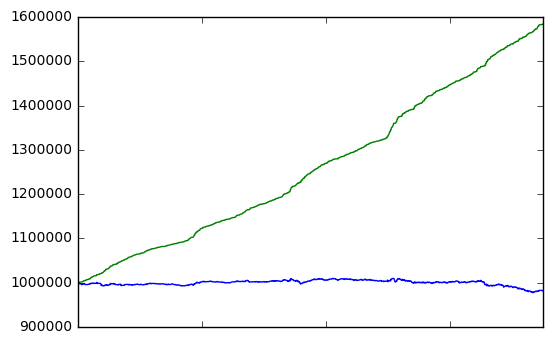

1.5838260175254706 0.9822050324770865 1.0665023603106296 904 588
-3.030798608136192


In [2]:
from datetime import timedelta
from pykalman import KalmanFilter
import matplotlib.pyplot as  plt
import pandas as pd
import numpy as np
from numpy.linalg import inv
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from alpha_vantage.timeseries import TimeSeries

s = 0.5 
n = 4 
n1 = 4
y = np.array([])
z = np.array([])
z_bench = np.array([])
predict_ind = np.array([])
predict = np.array([])
res = np.array([])
mean = 0
mean1 = 0
var1 = 0
var = 0
port = np.array([1000000])
port_ideal = np.array([1000000])
return_bench = np.array([])
return_strat = np.array([])
flag = 0
count = 0
count_ideal = 0

ts = TimeSeries(key='5Z1WW0XDW1MQWHGI', output_format='pandas')
df1, meta_data = ts.get_intraday(symbol='AMZN',interval='1min', outputsize='full')
df2, meta_data2 = ts.get_intraday(symbol='SPY',interval='1min', outputsize='full')

############################-I-N-I-T-I-A-L-I-Z-A-T-I-O-N-#############################################
print(df1)

kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 1400,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

state_means, _ = kf.filter(df1['4. close'])
state_means = pd.DataFrame(state_means.flatten(), index=df1.index)

df1['4. close'].plot()
state_means[0].plot()
plt.show()


for i in range(0,len(df1.index)-n+1):
    x = np.array([])
    for j in range(i,n+i-1):
#        x = np.append(x,np.array(df1['1. open'][j]))
#        x = np.append(x,np.array(df1['3. low'][j]))
        x = np.append(x,np.array(df1['4. close'][j]))
#        x = np.append(x,np.array(df1['2. high'][j]))
#        x = np.append(x,np.array(df1['5. volume'][j]))   
    z = np.append(z,np.array(df1['4. close'][i+n-1]))
    z_bench = np.append(z_bench,np.array(df2['4. close'][i+n-1]))
    predict_ind = np.append(predict_ind, np.array(df1.index[i+n-1]))
    y = np.concatenate((y,x))
  
y = np.reshape(y,(len(df1.index)-n+1,1*(n-1)))
z = np.reshape(z,(len(df1.index)-n+1,1))
z_bench = np.reshape(z,(len(df1.index)-n+1,1))

split = int(s*len(df1))
index_ = predict_ind[split:]
price_test = pd.DataFrame(z[split:])
price_test.index = index_
z_bench = z_bench[split:]

#############################-M-E-A-N--T-R-E-N-D--M-O-D-E-L-#######################
for i in range(0,len(index_)):
    y_train = y[i:split+i]
    y_test = y[split+i:]
    z_train = z[i:split+i]
    poly = PolynomialFeatures(1, interaction_only=False, include_bias=False)
    y_train = poly.fit_transform(y_train)
    y_test = poly.fit_transform(y_test)
    model = inv(np.transpose(y_train).dot(y_train)).dot(np.transpose(y_train).dot(z_train))
    predict_ = y_test.dot(model)
    predict = np.append(predict, predict_[0])
###########################-Y-U-L-E--W-A-L-K-E-R-###################################
    temp1 = y_train.dot(model)
    residue = temp1 - z_train - np.mean(temp1 - z_train)
    residue = np.reshape(residue, len(temp1))
    x = residue[-n1:]
    auto_corr = np.correlate(residue, residue, mode='full')/np.sum(residue**2)
    ac = auto_corr[int(auto_corr.size/2):n1+int(auto_corr.size/2)]
    cor = np.array([])
    for i in range(0,n1):
        cor = np.append(cor, np.roll(ac,i))
    cor = np.reshape(cor, (n1, n1))
    for i in range(0,n1):
        for j in range(i,n1):
            cor[j][i] = cor[i][j]
    ac1 = auto_corr[1+int(auto_corr.size/2):1+n1+int(auto_corr.size/2)]
    p = np.transpose(ac1[::-1]).dot(inv(cor)).dot(x)
    res = np.append(res, np.array(p+np.mean(temp1 - z_train)))    
    
predict = pd.DataFrame(predict)
residue = pd.DataFrame(res)
predict.index = index_
residue.index = index_
##############################-S-T-A-T-I-S-T-I-C-S-################################
plt.xlabel('Date')
plt.ylabel('Stock_price')

#d = predict - price_test
#temp = d[0] - np.mean(d[0])

d1 = predict
d1[1] = price_test
d1[2] = residue
#for i in range(1,len(index_)):
#    if np.datetime64(index_[i])-np.datetime64(index_[i-1]) != timedelta(seconds = 60):
#        d1.drop(index_[i], inplace=True)

d1[0].plot()
print(d1.index[0], d1.index[-1], len(d1))
d1[1].plot()
plt.show()

for i in range(0,len(d1)):
    mean = mean + (d1[0][d1.index[i]]-d1[1][d1.index[i]])/len(d1)
    mean1 = mean1 + (d1[0][d1.index[i]]-d1[1][d1.index[i]]+d1[2][d1.index[i]])/len(d1)    
    var = var + (d1[0][d1.index[i]]-d1[1][d1.index[i]])*(d1[0][d1.index[i]]-d1[1][d1.index[i]])/len(d1)           
    var1 = var1 + (d1[0][d1.index[i]]-d1[1][d1.index[i]]+d1[2][d1.index[i]])*(d1[0][d1.index[i]]-d1[1][d1.index[i]]+d1[2][d1.index[i]])/len(d1)           
    
std = sqrt(var) 
std1 = sqrt(var1) 
print(model)
print(mean, std, mean1, std1)

(d1[0]-d1[1]).plot()
plt.show()
(d1[0]-d1[1]+d1[2]).plot()
plt.show()
################################-A-U-T-O-C-O-R-R-E-L-A-T-I-O-N-########################################
corr = np.corrcoef(np.array(d1[0]),np.array(d1[1]))
print(corr)
corr = np.corrcoef(np.array(d1[0]-d1[2]),np.array(d1[1]))
print(corr)

temp = d1[0]-d1[1] - np.mean(d1[0]-d1[1])
auto_corr = np.correlate(temp, temp, mode='full')/np.sum(temp**2)
ac = auto_corr[int(auto_corr.size/2):int(auto_corr.size)]
plt.plot(auto_corr[int(auto_corr.size/2):50+int(auto_corr.size/2)], 'ro')
plt.axhline(y=1-0.9545)
plt.axhline(y=-1+0.9545)
plt.show()

temp = d1[0]-d1[1]+d1[2] - np.mean(d1[0]-d1[1]+d1[2])
auto_corr = np.correlate(temp, temp, mode='full')/np.sum(temp**2)
ac = auto_corr[int(auto_corr.size/2):int(auto_corr.size)]
plt.plot(auto_corr[int(auto_corr.size/2):50+int(auto_corr.size/2)], 'ro')
plt.axhline(y=1-0.9545)
plt.axhline(y=-1+0.9545)
plt.show()
###############################-T-I-M-E--S-E-R-I-E-S--A-N-A-L-Y-S-I-S-###################################
#temp = d[0] - np.mean(d[0])
#print(index_[0])
#split1 = int(len(temp)*s1)
#index_ = index_[split1:]
#a = predict[split1:]
#b = price_test[split1:]
#res = np.array([])
#for k in range(0,len(temp)-split1):
#    temp1 = temp[k:k+split1]
#    print(temp1.index[-1])
#    x = np.array(temp[k+split1-n1:k+split1])
#    auto_corr = np.correlate(temp1, temp1, mode='full')/np.sum(temp1**2)
#    ac = auto_corr[int(auto_corr.size/2):n1+int(auto_corr.size/2)]
#    print(ac,"z")
#    cor = np.array([])
#    for i in range(0,n1):
#        cor = np.append(cor, np.roll(ac,i))
#    cor = np.reshape(cor, (n1, n1))
#    for i in range(0,n1):
#        for j in range(i,n1):
#            cor[j][i] = cor[i][j]
#    ac = auto_corr[1+int(auto_corr.size/2):1+n1+int(auto_corr.size/2)]
#    print(ac,'a', ac[::-1], 'b', cor,'c',temp[k+split1-n1:k+split1],'d', x)
#    print("asdf")
#    p = np.transpose(ac[::-1]).dot(inv(cor)).dot(x)
#    print(p)
#    res = np.append(res, np.array(p+mean))
#
#residue = pd.DataFrame(res)
#residue.index = index_
#d2 =  a-b-residue
#corr = np.corrcoef(np.array(a[0]-residue[0]),np.array(b[0]))
#print(corr)
#
#d2.plot()
#plt.show()
#
#for i in range(1,len(index_)):
#    if np.datetime64(index_[i])-np.datetime64(index_[i-1]) != timedelta(seconds = 60):
#        d2.drop(index_[i], inplace=True)
#
#
#temp2 = d2[0] - np.mean(d2[0])
#auto_corr = np.correlate(temp2, temp2, mode='full')/np.sum(temp2**2)
#plt.plot(auto_corr[int(auto_corr.size/2):50+int(auto_corr.size/2)], 'ro')
#plt.axhline(y=1-0.9545)
#plt.axhline(y=-1+0.9545)
#plt.show()
##############################-P-O-R-T-F-O-L-I-O--A-N-A-L-Y-S-I-S-######################################
for i in range(0,len(index_)-1):
    if np.datetime64(index_[i+1])-np.datetime64(index_[i]) == timedelta(seconds = 60):
        if (predict[0][index_[i+1]]+residue[0][i+1]) > price_test[0][index_[i]]:
            if flag == 1:
                port = np.append(port, port[-1]+j*(price_test[0][index_[i+1]] - price_test[0][index_[i]]))        
            if flag == 0:
                j = port[-1]/price_test[0][index_[i]]
                port = np.append(port, port[-1]+j*(price_test[0][index_[i+1]] - price_test[0][index_[i]]))
                flag = 1
                count += 1
    
        else:
            if flag == 0:
                port = np.append(port, port[-1])        
                        
            if flag == 1:
                port = np.append(port, port[-1])
                flag = 0
                count += 1
    else :
            port = np.append(port, port[-1])
            if flag == 1:
                count+=1

flag = 0            
for i in range(0,len(index_)-1):
    if np.datetime64(index_[i+1])-np.datetime64(index_[i]) == timedelta(seconds = 60):
        if price_test[0][index_[i+1]] > price_test[0][index_[i]]:
            if flag == 1:
                port_ideal = np.append(port_ideal, port_ideal[-1]+j*(price_test[0][index_[i+1]] - price_test[0][index_[i]]))        
            if flag == 0:
                j = port_ideal[-1]/price_test[0][index_[i]]
                port_ideal = np.append(port_ideal, port_ideal[-1]+j*(price_test[0][index_[i+1]] - price_test[0][index_[i]]))
                flag = 1
                count_ideal += 1
    
        else:
            if flag == 0:
                port_ideal = np.append(port_ideal, port_ideal[-1])        
                        
            if flag == 1:
                port_ideal = np.append(port_ideal, port_ideal[-1])
                flag = 0
                count_ideal += 1
    else :
            port_ideal = np.append(port_ideal, port_ideal[-1])
            if flag == 1:
                count_ideal += 1
            
port_ideal1 = pd.DataFrame(port_ideal)            
port1 = pd.DataFrame(port)
port1.index = index_
port_ideal1.index = index_

port1[0].plot()
port_ideal1[0].plot()
plt.show()
print(port_ideal[-1]/(port_ideal[0]), port[-1]/(port[0]), price_test[0][-1]/price_test[0][0], count_ideal, count)
#################################-S-H-A-R-P-E--R-A-T-I-O-################################################
for i in range(0, len(index_)-1):
    return_strat = np.append(return_strat, (port[i+1]-port[i])/port[i])
    return_bench = np.append(return_bench, (z_bench[i+1]-z_bench[i])/z_bench[i])
SR = sqrt(len(index_)-1) * np.mean(return_strat-return_bench) / np.std(return_strat-return_bench)
print(SR)
#########################################################################################################